In [1]:
import math
import holdem.utils
import numpy as np
import gym
import holdem
from treys import Card
import holdem.DQN as DQN
import holdem.safePlayer as safePlayer
import tensorflow as tf

class action_table:
  CHECK = 0
  CALL = 1
  RAISE = 2
  FOLD = 3
    
def transferCard(cards):
    result = []
    for i in cards:
        rank = Card.get_rank_int(i)
        suit = Card.get_suit_int(i)
        suit = int(math.log2(suit))
        result.append(suit * 13 + rank)
    one_hot_encoding = np.zeros(52)
    one_hot_encoding[result] = 1
    return one_hot_encoding
        
def run_maze(model_list):
    step = 0
    how_many_round_ = [0,0,0,0]
    stack_record=[]
    for episode in range(15000):
        # initial observation
        (player_states, (community_infos, community_cards)) = env.reset()
        (player_infos, player_hands) = zip(*player_states)
        current_player = community_infos[-1]
        totalpot = community_infos[3]
        to_call = community_infos[6]
        stack = player_infos[current_player][2]
        handrank = player_infos[current_player][4]
        betting = player_infos[current_player][6]
        cards = [x for x in community_cards if x!=-1] + player_hands[current_player] 
        cards = transferCard(cards)
        
        # print(community_infos)
        # env.render(mode='human')
        terminal = False
        how_many_round=[0,0,0,0]
        while not terminal:
            RL = model_list[current_player]
            action = RL.choose_action(np.concatenate(([current_player, 
                                    totalpot,
                                    to_call,
                                    stack,
                                    handrank,
                                    betting],cards)))
            # first reound cannot check
#             print(action == 1 and to_call == 0)
#             print('action = ',action)
#             print()
#             if (action == 0 and cards.sum() == 2.0):
#                 action = 1
            if(action == 1 and to_call == 0):
                action = 0
            # cannot check when encounter other raised
            elif(action == 0 and to_call != 0):
                action = 1
            elif(action == 3 and to_call == 0):
                action = 0
            # print(action, cards.sum())
            result = [[0,0],[0,0],[0,0],[0,0]]
            result[current_player][0] = action
            if action==2:
                if stack < community_infos[5]:
                    result[current_player][0] = 1
                else:
                    result[current_player][1] = max(community_infos[4] + 10, 25)
            action = result
            # print(to_call)
#             print('action = ',action)
#             print('to_call = ', to_call)
            # rewards is an array
            (player_states_, (community_infos_, community_cards_)), rews, terminal, info = env.step(action)
#             env.render(mode='human')
            (player_infos_, player_hands_) = zip(*player_states)
#             print('rewards = ', rews)
#             print('terminal = ', terminal)
            
            current_player_ = community_infos_[-1]
            betting_ = player_infos_[current_player][6]
            totalpot_ = community_infos_[3]
            to_call_ = community_infos_[6]
            stack_ = player_infos_[current_player][2]
            handrank_ = player_infos_[current_player][4]
            betting_ = player_infos_[current_player][6]
            cards_ = [x for x in community_cards_ if x!=-1] + player_hands[current_player_] 
            cards_ = transferCard(cards_)
            
            
            RL.store_transition(np.concatenate(([current_player, 
                                totalpot,
                                to_call,
                                stack,
                                handrank,
                                betting] , cards))
                                , action, rews, np.concatenate(([current_player_, 
                                                        totalpot_,
                                                        to_call_,
                                                        stack_,
                                                        handrank_,
                                                        betting_], cards_)), current_player)

            stack_record.append(rews)
            # swap observation
            how_many_round[current_player] += 1
            
            stack = stack_
            current_player = current_player_
            betting = betting_
            to_call = to_call_
            player_states = player_states_
            community_infos = community_infos_
            community_cards = community_cards_
            
            #print('========step{} finished========'.format(step))
            step += 1
            
        # 最開頭的200步都不更新，只管亂走存到memory
        for i in range(4):
            model_list[i].replace_transition(rews[i], how_many_round_[i], how_many_round[i])
        if (step > 100):
            for i in range(4):
                model_list[i].learn()
    return stack_record
            

# env = gym.make('TexasHoldem-v1') # holdem.TexasHoldemEnv(2)

# # start with 2 players
# env.add_player(0, stack=500000) # add a player to seat 0 with 2000 "chips"
# env.add_player(1, stack=500000) # add another player to seat 1 with 2000 "chips"
# env.add_player(2, stack=500000)
# env.add_player(3, stack=500000)
# env.add_player(4, stack=500000)
# env.add_player(5, stack=500000)
# env.add_player(6, stack=500000)
# env.add_player(7, stack=500000)

# tf.reset_default_graph()

# RL1 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.01,
#                   reward_decay=0.9,
#                   e_greedy=0.9,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='1'
#                   )
# RL2 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.01,
#                   reward_decay=0.9,
#                   e_greedy=0.9,
#                   replace_target_iter=100,
#                   memory_size=500,
#                   output_graph=True, nickname='2'
#                   )
# RL3 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.03,
#                   reward_decay=0.9,
#                   e_greedy=0.85,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='3'
#                   )
# RL4 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.04,
#                   reward_decay=0.9,
#                   e_greedy=0.8,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='4'
#                   )
SP = safePlayer.safePlayer()
# RL5 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.05,
#                   reward_decay=0.9,
#                   e_greedy=0.75,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='5'
#                   )
# RL6 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.1,
#                   reward_decay=0.9,
#                   e_greedy=0.7,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='6'
#                   )
# RL7 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.3,
#                   reward_decay=0.9,
#                   e_greedy=0.65,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='7'
#                   )
# RL8 = DQN.DeepQNetwork(4, 58,
#                   learning_rate=0.5,
#                   reward_decay=0.9,
#                   e_greedy=0.6,
#                   replace_target_iter=100,
#                   memory_size=1000,
#                   output_graph=True, nickname='8'
#                   )
# final_result=[]
# for i in range(10):
#     stack_record = run_maze([SP, RL2, SP, SP])
#     final_result.append(stack_record)
# RL2.save_model()

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## save model

In [14]:

for i in range(1):
    env = gym.make('TexasHoldem-v1') # holdem.TexasHoldemEnv(2)

    # start with 2 players
    env.add_player(0, stack=500000) # add a player to seat 0 with 2000 "chips"
    env.add_player(1, stack=500000) # add another player to seat 1 with 2000 "chips"
    env.add_player(2, stack=500000)
    env.add_player(3, stack=500000)
    final_result=[]
    for i in range(3):
        stack_record = run_maze([SP, RL2, SP, SP])
        final_result.append(stack_record)
RL2.save_model()


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced


target_params_replaced



## load model

In [13]:
import math
import holdem.utils
import numpy as np
import gym
import holdem
from treys import Card
import holdem.DQN as DQN
import holdem.safePlayer as safePlayer
import tensorflow as tf

class action_table:
  CHECK = 0
  CALL = 1
  RAISE = 2
  FOLD = 3
    
RL2 = DQN.DeepQNetwork(4, 58,
                  learning_rate=0.008,
                  reward_decay=0.9,
                  e_greedy=0.9,
                  replace_target_iter=500,
                  memory_size=500,
                  output_graph=True, nickname='2'
                  )
RL2.load_model()

INFO:tensorflow:Restoring parameters from ./models/model.ckpt


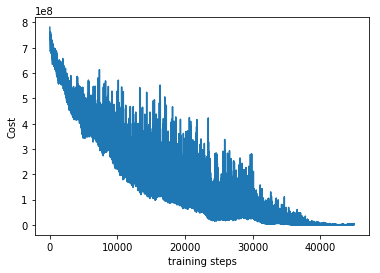

In [49]:
RL2.plot_cost()

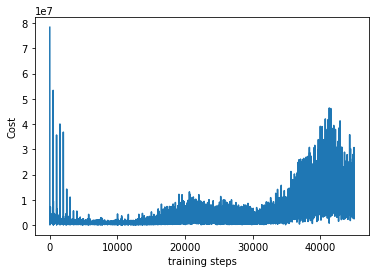

In [15]:
import matplotlib.pyplot as plt
# RL1.plot_cost()
RL2.plot_cost()
# RL3.plot_cost()
# RL4.plot_cost()
# RL5.plot_cost()
# RL6.plot_cost()
# RL7.plot_cost()
# RL8.plot_cost()

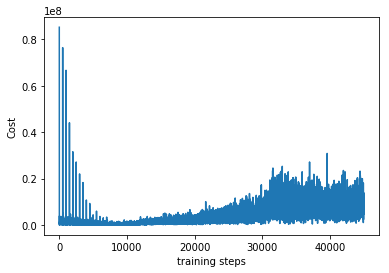

In [71]:
RL2.plot_cost()

/usr/local/lib/python3.6/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


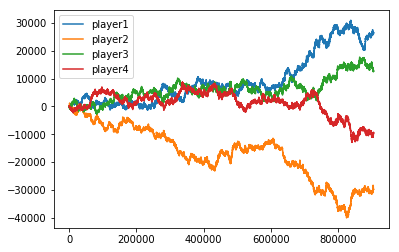

In [16]:
a0=np.array(final_result[0]+final_result[1]+final_result[2])
# a1=np.array(final_result[1])
# a2=np.array(final_result[2])
# a3=np.array(final_result[3])
# stack_record = np.concatenate((a0, a1, a2))
stack_record = a0

test = np.array(stack_record)
test = np.transpose(test)
l1 = plt.plot(np.arange(len(test[0])), test[0])
l2 = plt.plot(np.arange(len(test[1])), test[1])
l3 = plt.plot(np.arange(len(test[2])), test[2])
l4 = plt.plot(np.arange(len(test[3])), test[3])
# l5 = plt.plot(np.arange(len(test[4])), test[4])
# l6 = plt.plot(np.arange(len(test[5])), test[5])
# l7 = plt.plot(np.arange(len(test[6])), test[6])
# l8 = plt.plot(np.arange(len(test[7])), test[7])
plt.legend([l1,l2,l3,l4],labels=['player1','player2','player3','player4'])
plt.show()